# SMCN for ARMA prediction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import arma_generate_sample
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl

from ucn.models import SMCN
from src.trainer import SMCNTrainer
from src.dataset import ARMADataset

%load_ext autoreload
%autoreload 2

!rm -r lightning_logs/*

## Generate ARMA model and observations

In [2]:
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])

sigma_x = 0.8
sigma_y = 1.4

n_obs = 5000

Text(0.5, 1.0, 'ARMA model')

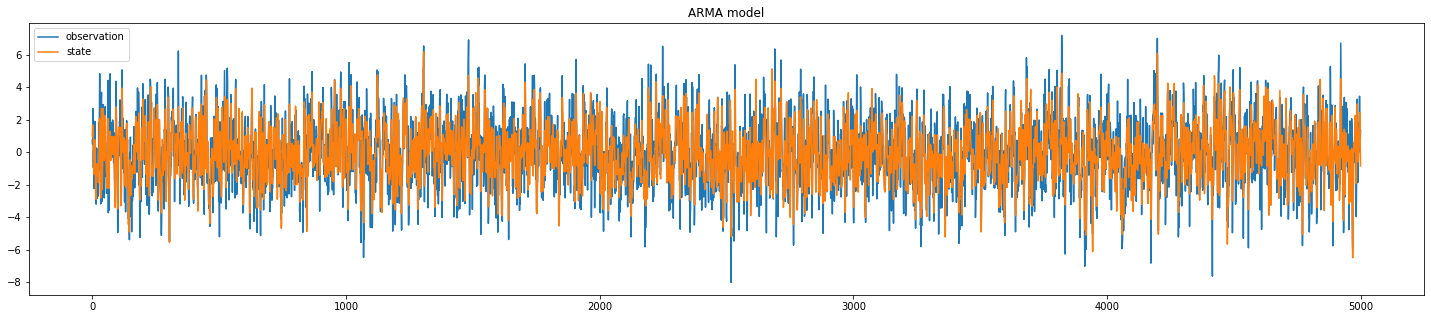

In [3]:
arparams = np.r_[1, -arparams]
maparams = np.r_[1, maparams]

x_arma = arma_generate_sample(arparams, maparams, n_obs, scale=sigma_x)

y_arma = x_arma + np.random.multivariate_normal((0,),
                                                np.diag([sigma_y]),
                                                size=len(x_arma)).squeeze()

plt.figure(figsize=(25, 5))
plt.plot(y_arma, label='observation')
plt.plot(x_arma, label='state')
plt.legend()
plt.title('ARMA model')

## SMCN Model

In [4]:
d_emb = 1
d_out = 1
N = 50

model = SMCN(d_emb, d_out, n_particles=N)

## Training

#### Dataset

In [5]:
T = 25
batch_size = 8
epochs = 30

dataset = ARMADataset(y_arma,
                      torch.zeros(len(y_arma), d_emb),
                      T)
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        num_workers=4,
                        shuffle=True
                       )

### Training loop

In [6]:
train_model = SMCNTrainer(model)
trainer = pl.Trainer(max_epochs=epochs, gpus=0)
trainer.fit(train_model, dataloader)

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/home/mrmojo/Code/these/uncertaintyQuantification/.env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name   | Type | Params
--------------------------------
0 | _model | SMCN | 8     
--------------------------------
8         Trainable params
0         Non-trainable params
8         Total params


Epoch 29: 100%|██████████| 25/25 [00:01<00:00, 13.12it/s, loss=0.0373, v_num=0]


1

In [7]:
print(f"Sigma_x ARMA:\t {sigma_x}")
print(f"Sigma_x model:\t", model._sigma_x.diag().detach().numpy().squeeze().round(1))
print(f"Sigma_y ARMA:\t {sigma_y}")
print(f"Sigma_y model:\t", model._sigma_y.diag().detach().numpy().squeeze().round(2))

Sigma_x ARMA:	 0.8
Sigma_x model:	 0.5
Sigma_y ARMA:	 1.4
Sigma_y model:	 0.31


## Visualization

In [8]:
def plot_range(array, label=None):
    plt.plot(array.mean(axis=-1), label=label)
    plt.fill_between(np.arange(len(array)), array.min(axis=-1), array.max(axis=-1), alpha=.3)

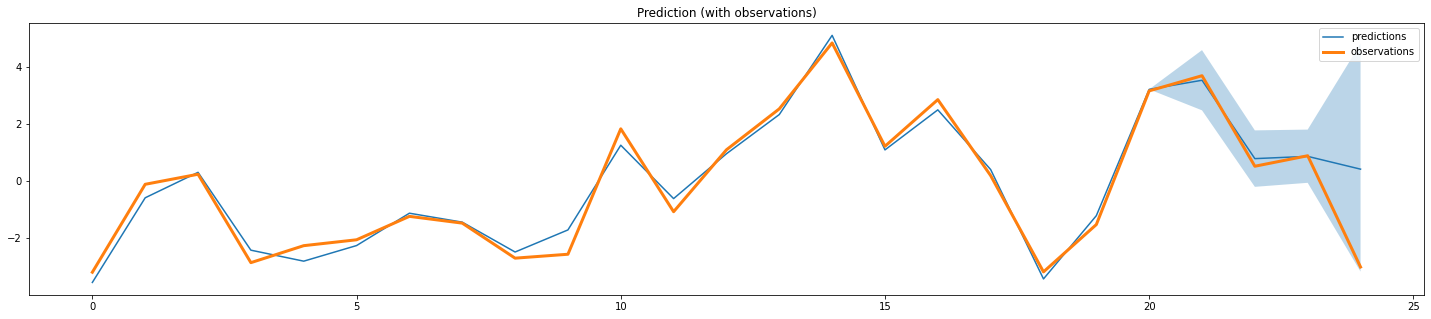

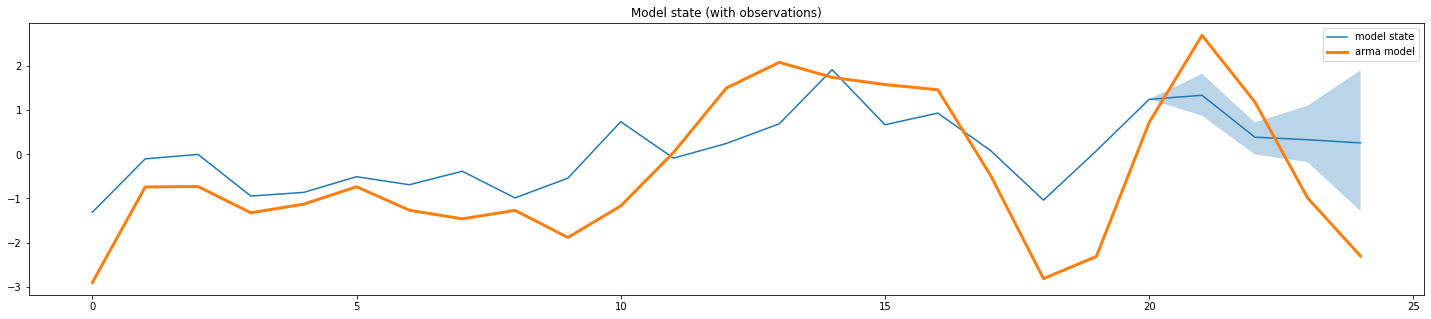

In [9]:
# Sample random time index
idx = np.random.randint(len(x_arma)-T)
x = x_arma[idx:idx+T]
y = y_arma[idx:idx+T]
u = torch.zeros((T, 1, d_emb))

# Run inference with observations
netout = model(u, noise=True, y=y)

netout = SMCN.smooth_pms(netout, model.I)
particules = SMCN.smooth_pms(model.particules, model.I)

netout = netout.detach().numpy().squeeze()
particules = particules.detach().numpy().squeeze()

plt.figure(figsize=(25, 5))
plot_range(netout, label='predictions')
plt.plot(y, lw=3, label='observations')
plt.title('Prediction (with observations)')
plt.legend()

plt.figure(figsize=(25, 5))
plot_range(particules, label='model state')
plt.plot(x, lw=3, label='arma model')
plt.title('Model state (with observations)')
plt.legend()

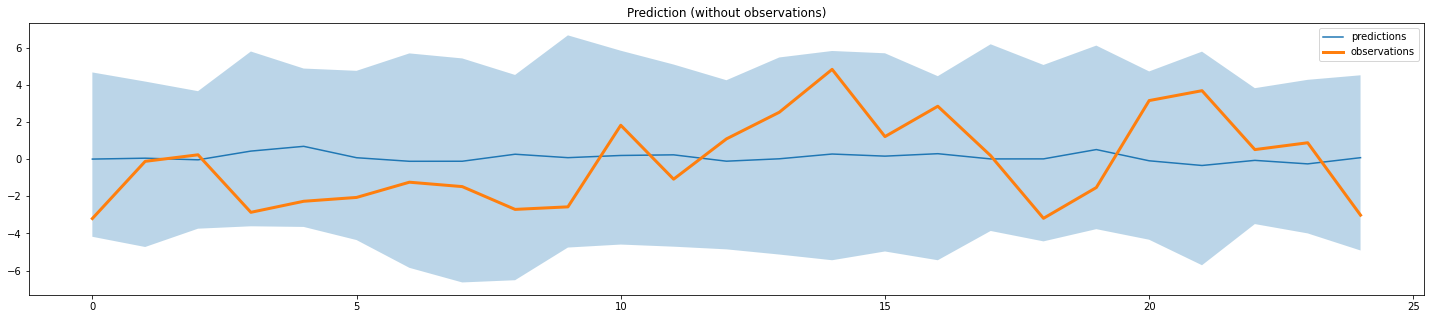

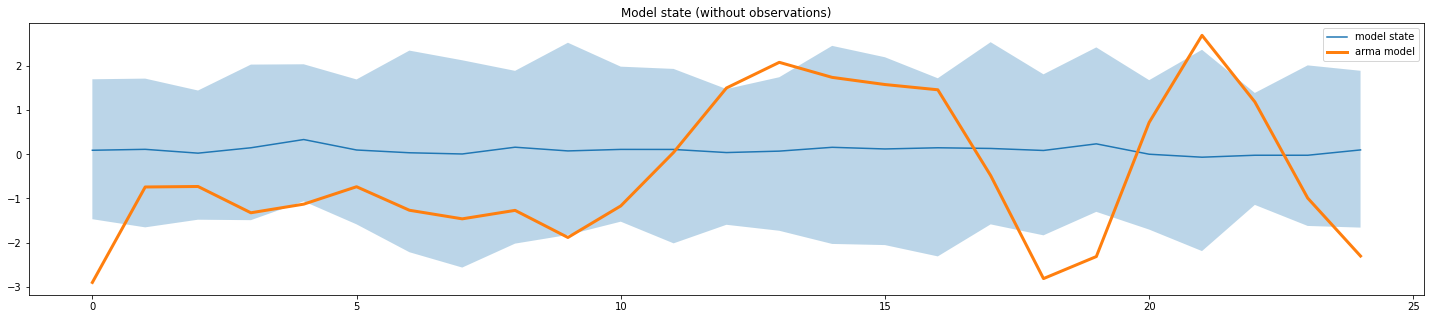

In [10]:
# Run inference withtout observation
netout = model(u, noise=True)

netout = netout.detach().numpy().squeeze()
particules = model.particules.detach().numpy().squeeze()

plt.figure(figsize=(25, 5))
plot_range(netout, label='predictions')
plt.plot(y, lw=3, label='observations')
plt.title('Prediction (without observations)')
plt.legend()

plt.figure(figsize=(25, 5))
plot_range(particules, label='model state')
plt.plot(x, lw=3, label='arma model')
plt.title('Model state (without observations)')
plt.legend()